In [80]:
import pandas as pd
import os
from datetime import datetime
import sqlite3
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
# function to convert datetime object to 4 - for force ONLY
def datetime(df, col_as_str):
    yearmonthday = df[col_as_str].astype(str).str.split(" ")
    ymd = yearmonthday.apply(lambda x: x[0]).str.split("/")
    year = ymd.apply(lambda x: x[2])
    month = ymd.apply(lambda x: x[0])
    day = ymd.apply(lambda x: x[1])
    time = ymd = yearmonthday.apply(lambda x: x[1]+x[2]).astype(str)
    df["year"] = year
    df["month"] = month
    df["day"] = day
    df["time"] = time
    return df


In [4]:
def callstime(df, col_arrive):
    yearmonthday = df[col_arrive].astype(str).str.split(" ")
    df["year"] = yearmonthday.apply(lambda x: x[2])
    df["day"] = yearmonthday.apply(lambda x: x[1])
    month_dict = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6, "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec":12}
    df["month"] = yearmonthday.apply(lambda x: month_dict[x[0]])
    df["time"] = yearmonthday.apply(lambda x: x[3])
    return df
    
    

In [5]:
calls = pd.read_csv("/Users/sarahburgart/galvanize/week7/capstone2/data/Call_Data.csv")

In [6]:
force = pd.read_csv("/Users/sarahburgart/galvanize/week7/capstone2/data/Use_Of_Force.csv")

In [7]:
#force.head()

In [7]:
#beats = pd.read_csv("/Users/sarahburgart/galvanize/week7/capstone2/data/Seattle_Police_Department_Beats.csv")

In [8]:
# change to epoch time
force = datetime(force,"Occured_date_time" )
foo = pd.to_datetime( force.Occured_date_time )
epoch_second = foo.map(lambda x:x.value/1e9)
#force.Occured_date_time

In [9]:
force["epoch"] = epoch_second

In [10]:
#force.head() # ID = Incident Num, Officer ID, Subject ID

In [11]:
calls = callstime(calls,"Arrived Time")


In [12]:
calls17 = calls[calls["year"].isin(["2014", "2015", "2016", "2017", "2018", "2019"])]

In [13]:
# calculate and add column for epoch time
bar = pd.to_datetime( calls17["Arrived Time"], format="%b %d %Y %I:%M:%S:%f%p" )
epoch_second2 = bar.map(lambda x: x.value/1e9)
calls17["epoch_calls"] = epoch_second2


/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [205]:
calls17["Event Clearance Description"].value_counts()
CITATION ISSUED (CRIMINAL OR NON-CRIMINAL) 
PHYSICAL ARREST MADE
OTHER REPORT MADE 
FOLLOW-UP REPORT MADE
PROBLEM SOLVING PROJECT 
STREET CHECK WRITTEN 
INCIDENT LOCATED, PUBLIC ORDER RESTORED 
TRANSPORTATION OR ESCORT PROVIDED 
- 
SERVICE OF DVPA ORDER
RADIO BROADCAST AND CLEAR
NON-CRIMINAL REFERRAL
EXTRA UNIT 
(NOT CURRENTLY USED) ALARM NO RESPONSE 
ASSISTANCE RENDERED 

ASSISTANCE RENDERED                           646727
REPORT WRITTEN (NO ARREST)                    329817
UNABLE TO LOCATE INCIDENT OR COMPLAINANT       99979
CITATION ISSUED (CRIMINAL OR NON-CRIMINAL)     58845
ORAL WARNING GIVEN                             57319
PHYSICAL ARREST MADE                           46362
OTHER REPORT MADE                              40863
NO POLICE ACTION POSSIBLE OR NECESSARY         38945
FALSE COMPLAINT/UNFOUNDED                      36911
PROBLEM SOLVING PROJECT                        34665
FOLLOW-UP REPORT MADE                          27541
STREET CHECK WRITTEN                           12005
DUPLICATED OR CANCELLED BY RADIO                8828
INCIDENT LOCATED, PUBLIC ORDER RESTORED         5320
TRANSPORTATION OR ESCORT PROVIDED               3932
RESPONDING UNIT(S) CANCELLED BY RADIO           3497
-                                               2224
SERVICE OF DVPA ORDER                            926
RADIO BROADCAST AND CLEAR                     

In [ ]:
# filter Event column for things that are associated with Force


In [14]:
# remove repetitive columns

calls_tosql = calls17.drop(columns =["year","day", "month", "time", "Precinct", "Sector", "Arrived Time"])
calls_tosql.set_index("epoch_calls", inplace=True)


In [15]:
# remove repetitive columns (incident type, officer id and subject id are in ID respectively)

force = force.drop(columns=["Occured_date_time", "ID"])


In [16]:
force[force.epoch == 1.398978e+09 ] #np.allclose

,Incident_Num,Incident_Type,Precinct,Sector,Beat,Officer_ID,Subject_ID,Subject_Race,Subject_Gender,year,month,day,time,epoch
799,1780,Level 1 - Use of Force,E,E,E1,1538,1680,White,Male,2014,05,01,09:00:00PM,1.398978e+09
1049,1549,Level 1 - Use of Force,W,D,D2,1682,341,White,Male,2014,05,01,09:00:00PM,1.398978e+09


In [17]:
#calls17.head()

In [18]:
# create engine
cnx = sqlite3.connect('/Users/sarahburgart/galvanize/week7/capstone2/calls.sqlite')

In [19]:
# move calls to sqlite table - DONT REPEAT
# calls_tosql.to_sql("log", con=cnx, index=True)


In [20]:
#calls_tosql.head()

In [21]:
# create cursor
cur = cnx.cursor()


In [22]:
'''test = cur.execute("SELECT * from log LIMIT 10").fetchall()
for row in test:
    print(row)

cnx.commit()'''

'test = cur.execute("SELECT * from log LIMIT 10").fetchall()\nfor row in test:\n    print(row)\n\ncnx.commit()'

In [156]:
# iterate through the dataframe 'force', make a bunch of new rows, and then make a dataframe out of those

new_row = []
#val_lst = []
for ix, row in force.iterrows():
    # query the 911 calls database
    # for each call, append to a bunch of records that we're building up into a dataframe
    value = row.epoch
    rowbeat = row.Beat
    vals = cur.execute(f"select * from log where epoch_calls BETWEEN ({value} - 300) AND {value} ").fetchall()
    #val_lst.extend([value, val[0]])
    cnx.commit()
    
    for val in vals:
        new_row.extend( [[ix,  val[0], row.epoch, row.Incident_Num, row.Officer_ID, row.Subject_ID, val[1], val[2],
                        row.Incident_Type, row.Precinct, 
                        row.Sector, row.Beat, val[8], val[4],
                        row.Subject_Race, row.Subject_Gender, val[3], val[5], val[6], 
                        val[7], row.year, row.month, row.day, row.time] ])
  

In [223]:
merged = pd.DataFrame(new_row, columns=["index","call_epoch", "force_epoch", "Incident_Num", "Officer_ID",
                                        "Subject_ID", "CAD_Event_Number", "Event_Clearance_Description",
                                "Force_Level", "Precinct", 
                                "Sector", "force_beat", "calls_beat", "Priority",
                                "Subject_Race", "Subject_Gender","Call_Type", "Initial_Call_Type", "Final_Call_Type",
                                "Original_Time_Queued", "year", "month","day", "time " ])



In [25]:
#merged.info()

In [224]:
merged.call_epoch = pd.to_numeric(merged.call_epoch, downcast="integer")
merged.force_epoch = pd.to_numeric(merged.force_epoch, downcast="integer")

In [225]:
# make numeric
rev_df = merged.replace("-1", -1)
rev_df["time"] = pd.to_datetime(rev_df["time "])
rev_df["Original_Time_Queued"] = pd.to_datetime(rev_df["Original_Time_Queued"])
rev_df["time"].apply(lambda x: pd.datetime.strftime(x, '%H:%M:%S'))




0        01:40:00
1        01:40:00
2        01:40:00
3        04:15:00
4        18:58:00
5        13:19:00
6        13:19:00
7        13:19:00
8        13:19:00
9        13:19:00
10       13:19:00
11       13:19:00
12       13:19:00
13       23:04:00
14       23:04:00
15       23:04:00
16       23:04:00
17       15:45:00
18       15:45:00
19       15:45:00
20       15:45:00
21       15:45:00
22       15:45:00
23       15:45:00
24       15:45:00
25       15:45:00
26       15:45:00
27       15:45:00
28       15:45:00
29       01:24:00
           ...   
27008    13:37:00
27009    13:37:00
27010    13:37:00
27011    13:37:00
27012    13:37:00
27013    13:37:00
27014    13:37:00
27015    13:37:00
27016    13:37:00
27017    13:37:00
27018    13:37:00
27019    13:37:00
27020    13:37:00
27021    13:37:00
27022    13:37:00
27023    13:37:00
27024    13:37:00
27025    14:00:00
27026    14:00:00
27027    14:00:00
27028    14:00:00
27029    17:20:00
27030    17:20:00
27031    17:20:00
27032    1

In [226]:
rev_df = pd.get_dummies(data = rev_df, 
                     columns=["force_beat","Force_Level", "calls_beat", "Event_Clearance_Description",
                              "Subject_Gender", "Call_Type","Subject_Race", "Initial_Call_Type", "Final_Call_Type",
                             "Precinct", "Sector", "Officer_ID", "Subject_ID"], 
                     prefix=["forceb", "forcelevel", "callsb", "ECD", 
                             "Gender", "CallType", "Race", "InitCall", "FinCall",
                            "Precinct","Sector", "OID", "SID" ])



# pd.get_dummies(data=df, columns=['A', 'B'])
                      

In [227]:

rev_df["year"] = rev_df["year"].astype(int)
rev_df["month"] = rev_df["month"].astype(int)
rev_df["day"] = rev_df["day"].astype(int)
rev_df["day_of_week"] = rev_df.Original_Time_Queued.dt.dayofweek


In [228]:
rev_df.drop("time ", axis=1, inplace=True)
rev_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27038 entries, 0 to 27037
Data columns (total 5651 columns):
index                                                          int64
call_epoch                                                     int64
force_epoch                                                    int64
Incident_Num                                                   int64
CAD_Event_Number                                               int64
Priority                                                       int64
Original_Time_Queued                                           datetime64[ns]
year                                                           int64
month                                                          int64
day                                                            int64
time                                                           datetime64[ns]
forceb_-                                                       uint8
forceb_99                                  

In [229]:
# exploring unsupervised learning

# make appropriate array to use SVD
svdf = rev_df.drop(["time", "Original_Time_Queued"], axis=1)
sdf = svdf.iloc[:10000, :]

In [ ]:
u, s, vh = np.linalg.svd(sdf)

In [ ]:
power = s*2
total_power = sum(power)
total_power

In [ ]:
vh.shape, s.shape, u.shape, svdf.shape

In [ ]:
svV  = pd.DataFrame(vh[:10])
svV.columns = svdf.columns
svV

In [ ]:
sv0 = svV.iloc[0,:]
sv0 = abs(sv0)
np.argmax(sv0)
sv0[6] # equals CAD_Event_Number
#svV.iloc[0,:]

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=659, oob_score=True)

In [ ]:
rev_df.info(verbose=True)

In [ ]:
X = rev_df.drop(["index", "call_epoch", "force_epoch", "Incident_Num", "CAD_Event_Number", "Original_Time_Queued",
                "forcelevel_Level 1 - Use of Force", "forcelevel_Level 2 - Use of Force", "forcelevel_Level 3 - OIS",
                "forcelevel_Level 3 - Use of Force", "time"], axis=1)

X.columns, X.shape

In [217]:
event_lst = ["CITATION ISSUED (CRIMINAL OR NON-CRIMINAL) ",
"PHYSICAL ARREST MADE",
"OTHER REPORT MADE" ,
"FOLLOW-UP REPORT MADE",
"PROBLEM SOLVING PROJECT" ,
"STREET CHECK WRITTEN ",
"INCIDENT LOCATED, PUBLIC ORDER RESTORED ",
"TRANSPORTATION OR ESCORT PROVIDED", 
"-",
"SERVICE OF DVPA ORDER",
"RADIO BROADCAST AND CLEAR",
"NON-CRIMINAL REFERRAL",
"EXTRA UNIT" ,
"(NOT CURRENTLY USED) ALARM NO RESPONSE" ] 

In [179]:
y = merged.Force_Level
y.replace({"Level 1 - Use of Force":1,"Level 2 - Use of Force":2,"Level 3 - OIS":4, "Level 3 - Use of Force": 3 })
y.shape

(27038,)

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=659)


In [181]:
clf.fit(X_train, y_train )

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=659, verbose=0, warm_start=False)

In [182]:
len(clf.feature_importances_), len(X.columns)

indices = np.argsort(clf.feature_importances_)
big = indices[-20:]

X.columns[big]

Index(['Race_Hispanic or Latino', 'Sector_M',
       'CallType_TELEPHONE OTHER, NOT 911', 'ECD_REPORT WRITTEN (NO ARREST)',
       'CallType_ONVIEW', 'Precinct_W', 'CallType_911',
       'ECD_ASSISTANCE RENDERED', 'Race_Not Specified', 'Gender_Male',
       'Race_White', 'Race_Black or African American', 'Gender_Female',
       'Priority', 'year', 'day_of_week', 'month', 'day', 'Subject_ID',
       'Officer_ID'],
      dtype='object')

In [183]:
clf.oob_score_ # accuracy of training set

0.9143781784558483

In [184]:
yhat = clf.predict(X_test)

In [185]:
sum(yhat == y_test) / len(yhat) # accuracy of testing set

0.9132766272189349

In [221]:
subj_id = rev_df[rev_df.Subject_ID ==  19587]
one = subj_id[subj_id.force_epoch == 1553702700]
sub_id = merged[merged["Subject_ID"] == 19587]
again = sub_id[sub_id["Event_Clearance_Description"].isin(event_lst)]
again.CAD_Event_Number.value_counts()

2019000108957    3
2019000109015    1
2019000109025    1
Name: CAD_Event_Number, dtype: int64

In [202]:
force.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9838 entries, 0 to 9837
Data columns (total 14 columns):
Incident_Num      9838 non-null int64
Incident_Type     9838 non-null object
Precinct          9838 non-null object
Sector            9838 non-null object
Beat              9838 non-null object
Officer_ID        9838 non-null int64
Subject_ID        9838 non-null int64
Subject_Race      9838 non-null object
Subject_Gender    9838 non-null object
year              9838 non-null object
month             9838 non-null object
day               9838 non-null object
time              9838 non-null object
epoch             9838 non-null float64
dtypes: float64(1), int64(3), object(10)
memory usage: 1.1+ MB


In [198]:
calls.columns

Index(['CAD Event Number', 'Event Clearance Description', 'Call Type',
       'Priority', 'Initial Call Type', 'Final Call Type',
       'Original Time Queued', 'Arrived Time', 'Precinct', 'Sector', 'Beat',
       'year', 'day', 'month', 'time'],
      dtype='object')

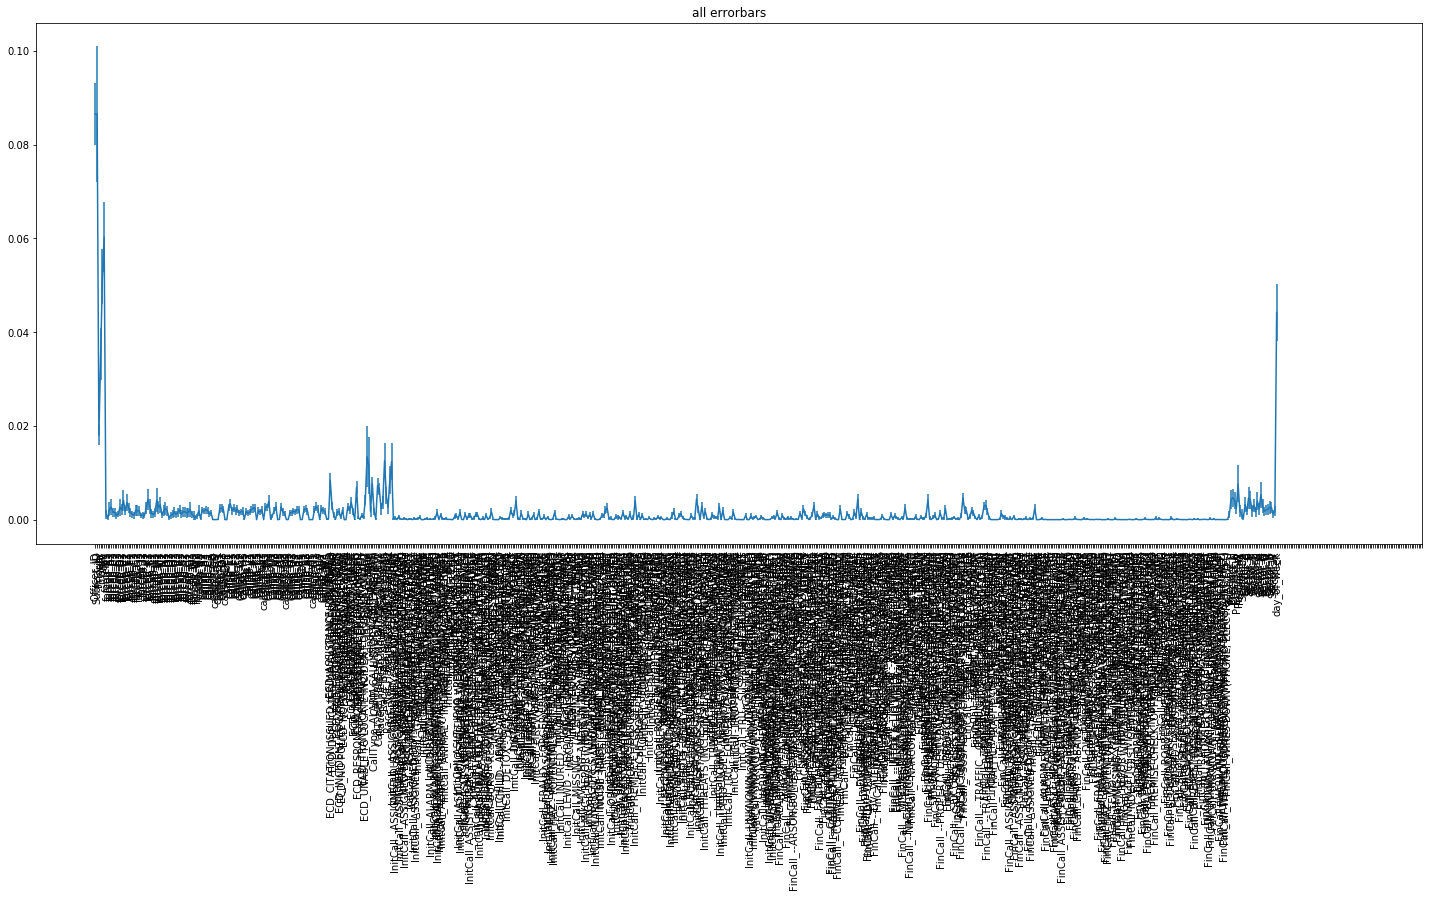

In [187]:

importance = np.std([tree.feature_importances_
                            for tree in clf.estimators_], axis=0)

r = range(importance.shape[0])
f = clf.feature_importances_
yerr = importance

# Extend the code to find the standard deviation of the importance for each feature across all trees. 
fig, ax = plt.subplots(1,1, figsize=(20,8), sharex=True)
#axs.flatten()

ax.errorbar(r,f, yerr=yerr)
ax.set_title('all errorbars')


#fig.suptitle('Errors')

plt.tight_layout()
plt.xticks(np.arange(758), X.columns, rotation="vertical")
plt.show();
#plt.bar(r, f, yerr=yerr, align="center");




In [ ]:
'''force3.Incident_Num.value_counts()
t = force3[force3["Incident_Num"] == 12308]
#t.drop_duplicates("CAD_Event_Number", inplace=True) # 'force_beat', 'calls_beat'
len(t.CAD_Event_Number.value_counts()), len(t)
t2 = t[t.force_beat.values == t.calls_beat.values]
t2'''

'''force3 = merged[merged.Force_Level == "Level 3 - Use of Force"]
force2 = merged[merged.Force_Level == "Level 2 - Use of Force"]
force1 = merged[merged.Force_Level == "Level 1 - Use of Force"]
len(force3), len(force2), len(force1), len(merged)'''

'''# group by incident number first

x = force3.Subject_Race.value_counts()
lst = list(x.values)
plt.bar(np.arange(7), lst)
#plt.xticks([])
#plt.xticks()

plt.xticks((0,1, 2, 3,4,5,6), ('White', 'Black or African American ', 'Not Specified ','Hispanic or Latino',
                               'Asian','American Indian/Alaska Native ','Nat Hawaiian/Oth Pac Islander'), 
          rotation='vertical')
plt.title("Level 3 Force by Race 2014-2019");'''

In [ ]:
'''force3beats = force3[force3.force_beat.values == force3.calls_beat.values]
len(force3beats)
f3b = force3beats.drop(["index", "Force_Level", "Precinct"], axis=1)
f3b.drop("Sector", axis=1, inplace=True)
#f3b '''

In [ ]:
'''#rev_df.drop(["Subject_Gender", "Subject_Race"], axis=1, inplace=True)
rev_df.info(verbose=True)'''

In [ ]:
'''y = force3.Subject_Gender.value_counts()
lst = list(y.values)
plt.bar(np.arange(2), lst)
#plt.xticks([])
#plt.xticks()

plt.xticks((0,1), ('Male', 'Female'), 
          rotation='horizontal')
plt.title("Level 3 Force by Gender 2014-2019");'''

In [ ]:
'''ecd = list(enumerate(merged.Event_Clearance_Description.value_counts().index))
ecdict  = {x:i for i,x in enumerate(merged.Event_Clearance_Description.value_counts().index)}
ecdict'''

In [ ]:

fig, ax = plt.subplots(1,1, figsize=(20,12))
fct = force3.Final_Call_Type.value_counts()
lst = list(fct.values)
plt.bar(np.arange(99), lst)
#plt.xticks([])
#plt.xticks()

plt.xticks(np.arange(99), lst,  rotation='vertical')
plt.title("Level 3 Force by Final Call Type 2014-2019");